In [1]:
library("knitr")
library("glmnet")
library("ggplot2")
library("tidyverse")
library("tidymodels")
library("data.table")

Loading required package: Matrix

Loaded glmnet 4.1-3

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ──────────────────────────────────────────────────────

## Lasso-penalised logistic regression using tidymodels

For this illustration, we will use the metabolomics dataset on NMR spectroscopy metabolite abundances in diabetes patients (with controls):

In [2]:
mtbsl1 <- fread("../data/MTBSL1.tsv")
nrow(mtbsl1)

[1] 132

In [3]:
head(mtbsl1)

Primary ID,Gender,Metabolic_syndrome,[0.10 .. 0.14],[0.14 .. 0.16],[0.16 .. 0.21],[0.21 .. 0.24],[0.24 .. 0.29],[0.29 .. 0.32],[0.32 .. 0.35],⋯,[8.93 .. 8.99],[8.99 .. 9.02],[9.02 .. 9.07],[9.07 .. 9.10],[9.10 .. 9.14],[9.14 .. 9.18],[9.18 .. 9.22],[9.22 .. 9.25],[9.25 .. 9.31],[9.31 .. 9.35]
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADG10003u_007,Male,diabetes mellitus,0.0108030,0.00143490,0.0091003,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0149840,0.0016981,0.0000000,0,0.0981400,0.0047125,0.0012483,0,0.01145300,0
ADG10003u_008,Male,diabetes mellitus,0.0031735,0.00000000,0.0044487,0.0000000,0.0000000,0.0000000,0.0011089,⋯,0.0129970,0.0000000,0.0028833,0,0.0871570,0.0000000,0.0000000,0,0.00870710,0
ADG10003u_009,Male,diabetes mellitus,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0062194,0.0000000,0.0000000,0,0.1396500,0.0000000,0.0000000,0,0.00043927,0
ADG10003u_010,Male,diabetes mellitus,0.0081798,0.00000000,0.0012897,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0,0.0748370,0.0000000,0.0000000,0,0.00000000,0
ADG10003u_015,Female,diabetes mellitus,0.0183760,0.00083177,0.0236020,0.0059512,0.0068872,0.0055841,0.0027941,⋯,0.0061944,0.0000000,0.0000000,0,0.0003152,0.0000000,0.0000000,0,0.00847050,0
ADG10003u_016,Female,diabetes mellitus,0.0145490,0.00233040,0.0170260,0.0061882,0.0090057,0.0032542,0.0044506,⋯,0.0000000,0.0000000,0.0000000,0,0.0233290,0.0000000,0.0000000,0,0.00000000,0


In [21]:
names(mtbsl1)[c(4:ncol(mtbsl1))] <- paste("mtbl",seq(1,ncol(mtbsl1)-3), sep = "_")
print(paste("N. of columns;", ncol(mtbsl1)))

[1] "N. of columns; 191"


We have **132 records** and **189 variables** (191 - 2 (`ID` and `Metabolic_syndrome`)): still, $p > n$.
We see now the distribution of classes (control, diabetes) per sex (not dramatically unbalanced):

In [22]:
table(mtbsl1$Metabolic_syndrome,mtbsl1$Gender)

                   
                    Female Male
  Control Group         28   56
  diabetes mellitus     26   22

We can see that the metabolites abundances have largely different scales/magnitudes, and it could be a good idea to normalise them before running the model (remember that Lasso constraints the size of the coefficients, and these depend on the magnitude of each variable $\rightarrow$ same $\lambda$ applied to all variables).

This is the range between maximum values across metabolites:

In [24]:
mm_diab <- mtbsl1 %>%
  gather(key = "metabolite", value = "abundance", -c(`Primary ID`,Gender,Metabolic_syndrome))

group_by(mm_diab, metabolite) %>% summarise(max_each=max(abundance)) %>% summarise(min = min(max_each), max = max(max_each))

min,max
<dbl>,<dbl>
0.005797,21.399


Below the boxplots of the distributions of values for all metabolites:

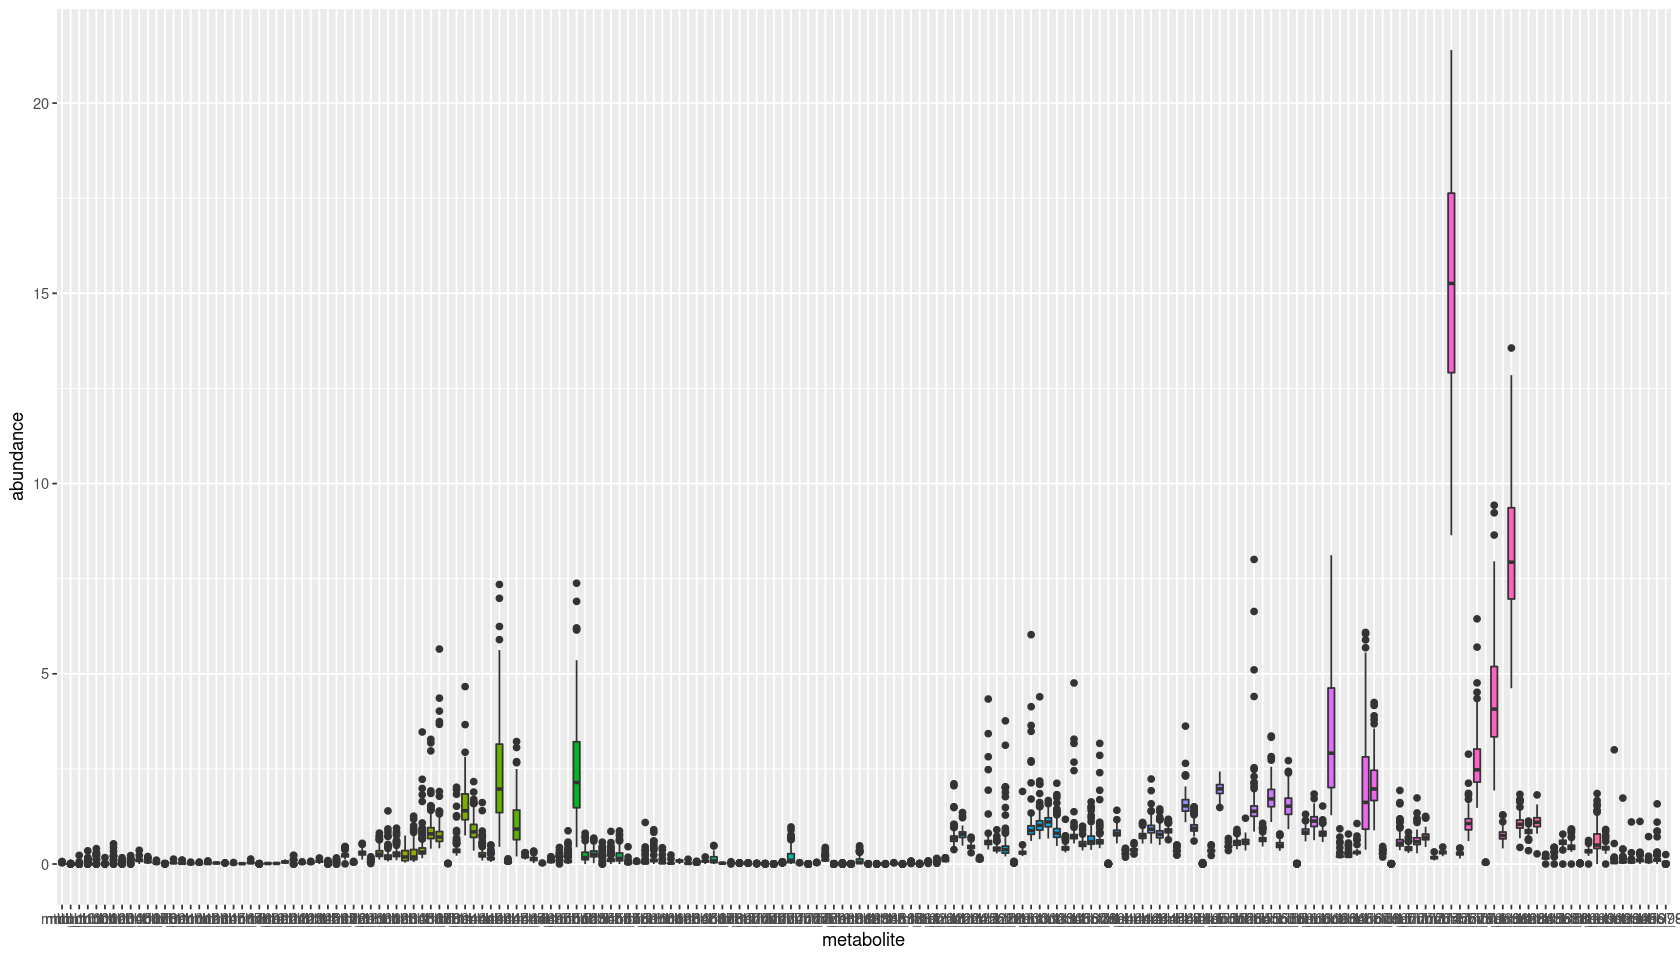

In [25]:
library("repr")
options(repr.plot.width=14, repr.plot.height=8)

mm_diab %>%
  ggplot(aes(metabolite, abundance, fill = as.factor(metabolite))) +
  geom_boxplot(show.legend = FALSE)

### Training and test sets

We now split the data in the training and test sets using `tidymodels` functions: we now split in a stratified way, because we want to keep a similar proportion of cases and controls in both the training and test sets. 

In [26]:
diab_dt <- select(mtbsl1, -c(`Primary ID`, Gender)) ## remove gender for the moment, and keep only numeric features for convinience
mtbsl1_split <- initial_split(diab_dt, strata = Metabolic_syndrome)
mtbsl1_train <- training(mtbsl1_split)
mtbsl1_test <- testing(mtbsl1_split)

### Preprocessing

We remove variables with zero variance (no variability, not informative) and normalise all numeric variables: to do so, we build a preprocessing "recipe", where we specify:

- the model equation: diabetes/control as a function of all metabolites
- remove all predictors (non-outcome variables) that don't have variance
- normalize all numeric predictors (standard deviation of one and a mean of zero)

In [27]:
## build a recipe for preprocessing
mtbsl1_rec <- recipe(Metabolic_syndrome ~ ., data = mtbsl1_train) %>%
  # update_role(`Primary ID`, new_role = "ID") %>%
  step_zv(all_numeric(), -all_outcomes()) %>%
  step_normalize(all_numeric(), -all_outcomes())

print(mtbsl1_rec)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        188

Operations:

Zero variance filter on all_numeric(), -all_outcomes()
Centering and scaling for all_numeric(), -all_outcomes()


Now we use the `tidymodels` functions `prep()` and `juice()` to obtain the preprocessed training set:

In [30]:
mtbsl1_prep <- mtbsl1_rec %>%
  prep(strings_as_factors = FALSE)

print(mtbsl1_prep)
mtbsl1_train <- juice(mtbsl1_prep)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        188

Training data contained 99 data points and no missing data.

Operations:

Zero variance filter removed no terms [trained]
Centering and scaling for mtbl_1, mtbl_2, mtbl_3, mtbl_4, mtbl_5, ... [trained]


In [31]:
mm_train <- mtbsl1_train %>%
  gather(key = "metabolite", value = "abundance", -c(Metabolic_syndrome))

print(group_by(mm_train, metabolite) %>% summarise(mean(abundance),sd(abundance)))

# A tibble: 188 × 3
   metabolite `mean(abundance)` `sd(abundance)`
   <chr>                  <dbl>           <dbl>
 1 mtbl_1             -2.74e-17               1
 2 mtbl_10             6.28e-18               1
 3 mtbl_100            1.63e-17               1
 4 mtbl_101            1.51e-17               1
 5 mtbl_102           -6.97e-17               1
 6 mtbl_103            9.24e-17               1
 7 mtbl_104           -9.09e-17               1
 8 mtbl_105            6.08e-17               1
 9 mtbl_106           -1.96e-16               1
10 mtbl_107            1.04e-16               1
# … with 178 more rows


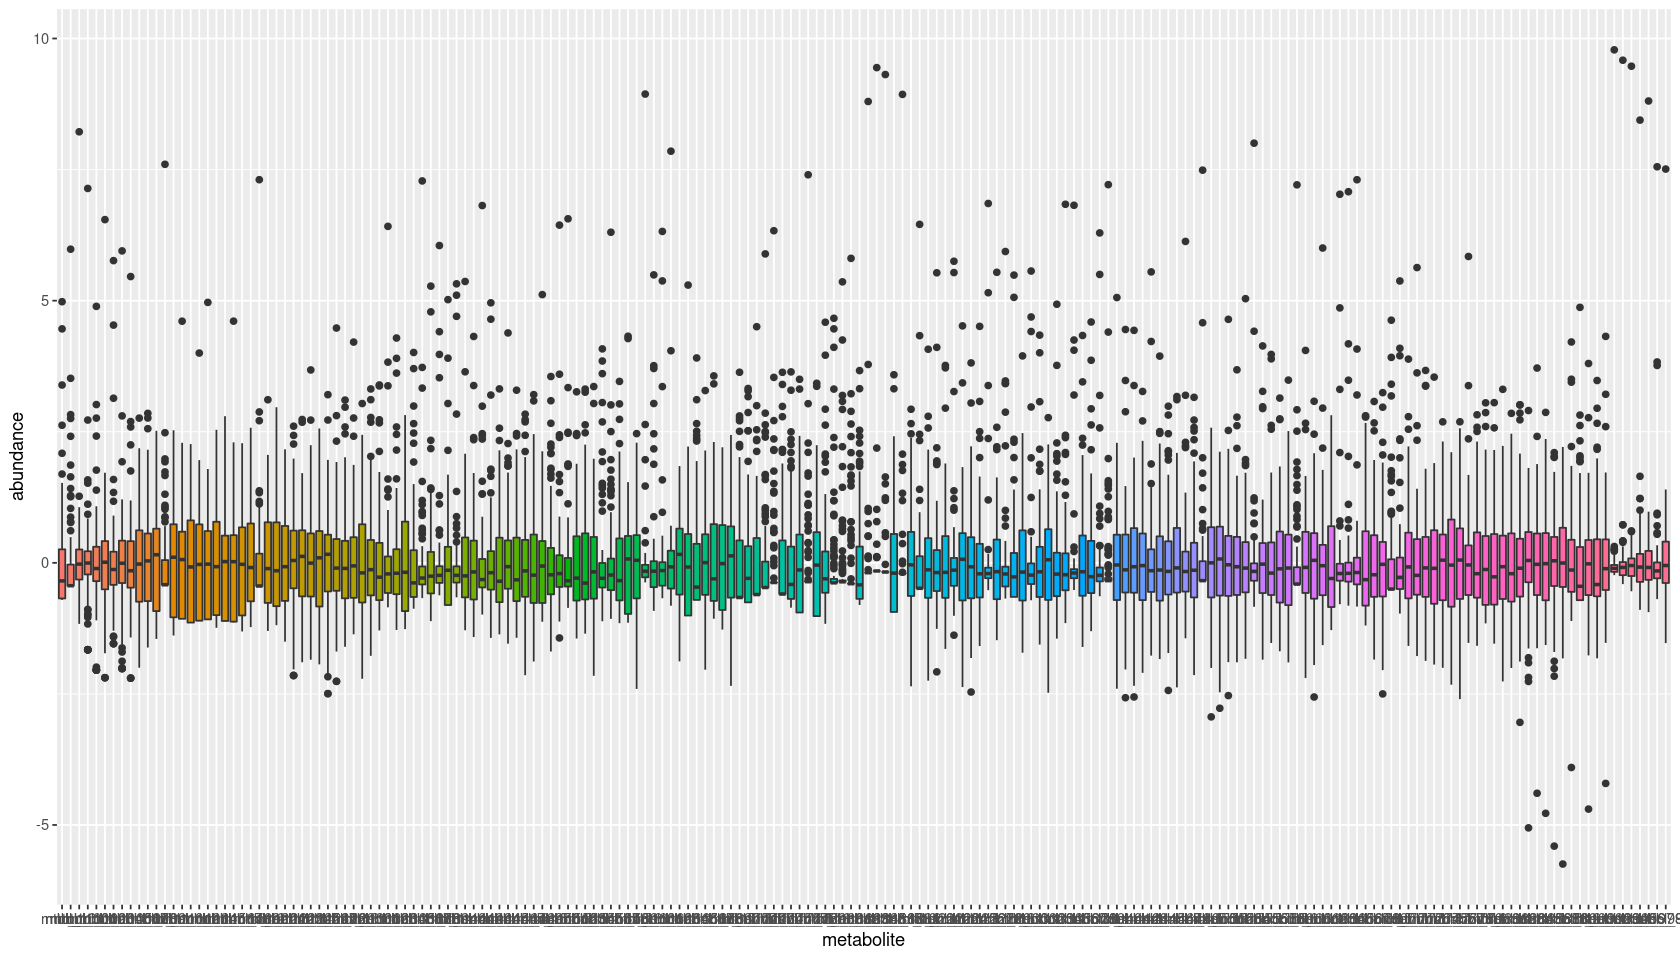

In [32]:
options(repr.plot.width=14, repr.plot.height=8)
mm_train %>%
  ggplot(aes(metabolite, abundance, fill = as.factor(metabolite))) +
  geom_boxplot(show.legend = FALSE)

## The Lasso model

We start by specifying our Lasso model:

- it's logistic regression for a classification problem
- we set the $\lambda$ parameter (penalty) to the arbitrary value of 0.1
- mixture: amount of L1 regularization, when 1 it's Lasso (0 is Ridge regression)
- the engine is set to `glmnet`

Then we add everything to a workflow object, piecewise, and fit the Lasso model:

In [38]:
lasso_spec <- logistic_reg(mode = "classification", penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet")
print(lasso_spec)

Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = 0.1
  mixture = 1

Computational engine: glmnet 



In [45]:
wf <- workflow() %>%
  add_recipe(mtbsl1_rec) %>%
  add_model(lasso_spec)

In [46]:
lasso_fit <- wf %>%
  fit(data = mtbsl1_train)

In [47]:
lasso_fit %>%
  pull_workflow_fit() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),-0.69148898,0.1
mtbl_1,0.00000000,0.1
mtbl_2,0.00000000,0.1
mtbl_3,0.00000000,0.1
mtbl_4,0.00000000,0.1
mtbl_5,0.00000000,0.1
mtbl_6,0.00000000,0.1
mtbl_7,0.00000000,0.1
mtbl_8,0.22895346,0.1


In [48]:
lasso_fit %>%
  pull_workflow_fit() %>%
  tidy() %>%
  filter(estimate > 0)

term,estimate,penalty
<chr>,<dbl>,<dbl>
mtbl_8,0.228953456,0.1
mtbl_13,0.048024619,0.1
mtbl_28,0.395355687,0.1
mtbl_48,0.093002342,0.1
mtbl_101,0.018441206,0.1
mtbl_104,0.057383391,0.1
mtbl_141,0.181339115,0.1
mtbl_144,0.008678112,0.1
mtbl_164,0.228303203,0.1


## Tuning the hyperparameters

We use k-fold cross-validation to tune the hyperparameters ($\lambda$ penalty in this case) in the training set:

- `vfold_cv`: to specify n. of folds (stratified) and replicates
- `logistic_reg`: to specify that we want a logistic regression model for classification, we want to use Lasso penalization, and we are fine-tuning the penalty parameter
- `grid_regular`: defines the range of penalty parameter values to try

In [49]:
diab_cv <- vfold_cv(mtbsl1_train, v=5, repeats = 10, strata = Metabolic_syndrome)

tune_spec <- logistic_reg(mode = "classification", penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

lambda_grid <- grid_regular(penalty(), levels = 50, filter = penalty <= .05)
print(lambda_grid)

# A tibble: 43 × 1
    penalty
      <dbl>
 1 1   e-10
 2 1.60e-10
 3 2.56e-10
 4 4.09e-10
 5 6.55e-10
 6 1.05e- 9
 7 1.68e- 9
 8 2.68e- 9
 9 4.29e- 9
10 6.87e- 9
# … with 33 more rows


In [55]:
wf1 <- workflow() %>%
  add_recipe(mtbsl1_rec) %>%
  add_model(tune_spec) ## remember: the model equation was specified in the recipe (top of this document)

print(wf1)

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_zv()
• step_normalize()

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = tune()
  mixture = 1

Computational engine: glmnet 



We are now ready to **fine-tune the model**!!

In [56]:
doParallel::registerDoParallel()

lasso_grid <- tune_grid(
  wf1,
  resamples = diab_cv,
  grid = lambda_grid
)

Here we can see the results for each value of the penalty parmeter that was tried in the fine-tuning process:

In [53]:
lasso_grid %>%
  collect_metrics()

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.000000e-10,accuracy,binary,0.9425088,50,0.008464582,Preprocessor1_Model01
1.000000e-10,roc_auc,binary,0.9781685,50,0.004661571,Preprocessor1_Model01
1.599859e-10,accuracy,binary,0.9425088,50,0.008464582,Preprocessor1_Model02
1.599859e-10,roc_auc,binary,0.9781685,50,0.004661571,Preprocessor1_Model02
2.559548e-10,accuracy,binary,0.9425088,50,0.008464582,Preprocessor1_Model03
2.559548e-10,roc_auc,binary,0.9781685,50,0.004661571,Preprocessor1_Model03
4.094915e-10,accuracy,binary,0.9425088,50,0.008464582,Preprocessor1_Model04
4.094915e-10,roc_auc,binary,0.9781685,50,0.004661571,Preprocessor1_Model04
6.551286e-10,accuracy,binary,0.9425088,50,0.008464582,Preprocessor1_Model05


Plotting the results will help us see what happened during fine-tuning of the model, and then select the best value for $\lambda$ (the penalty parameter) based on the maximum AUC (binary classification problem):

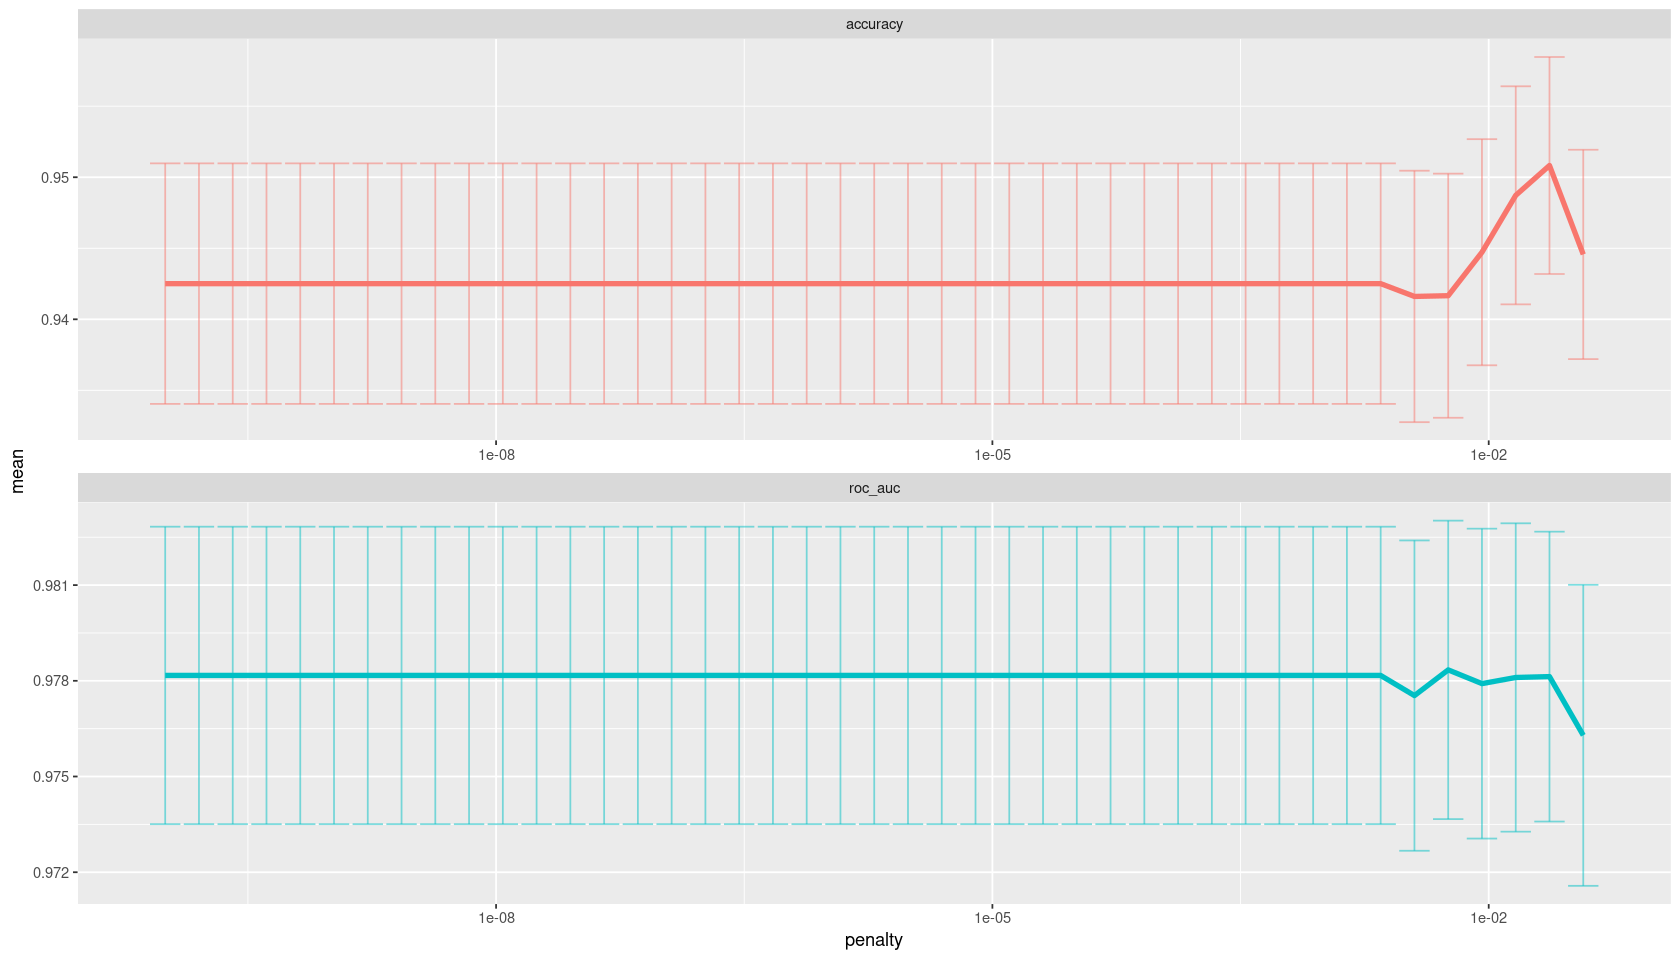

In [59]:
lasso_grid %>%
  collect_metrics() %>%
  ggplot(aes(penalty, mean, color = .metric)) +
  geom_errorbar(aes(
    ymin = mean - std_err,
    ymax = mean + std_err
  ),
  alpha = 0.5
  ) +
  geom_line(size = 1.5) +
  facet_wrap(~.metric, scales = "free", nrow = 2) +
  scale_x_log10() +
  theme(legend.position = "none")

In [60]:
lowest_roc <- lasso_grid %>%
  select_best("roc_auc")

print(lowest_roc)

# A tibble: 1 × 2
  penalty .config              
    <dbl> <chr>                
1 0.00569 Preprocessor1_Model39


With the selected penalty parameter from fine-tuning, we can (finally!)  finalize our workflow: 

In [61]:
final_lasso <- finalize_workflow(
  wf1,
  lowest_roc
)

print(final_lasso)

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_zv()
• step_normalize()

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = 0.00568986602901831
  mixture = 1

Computational engine: glmnet 



### Variable importance


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




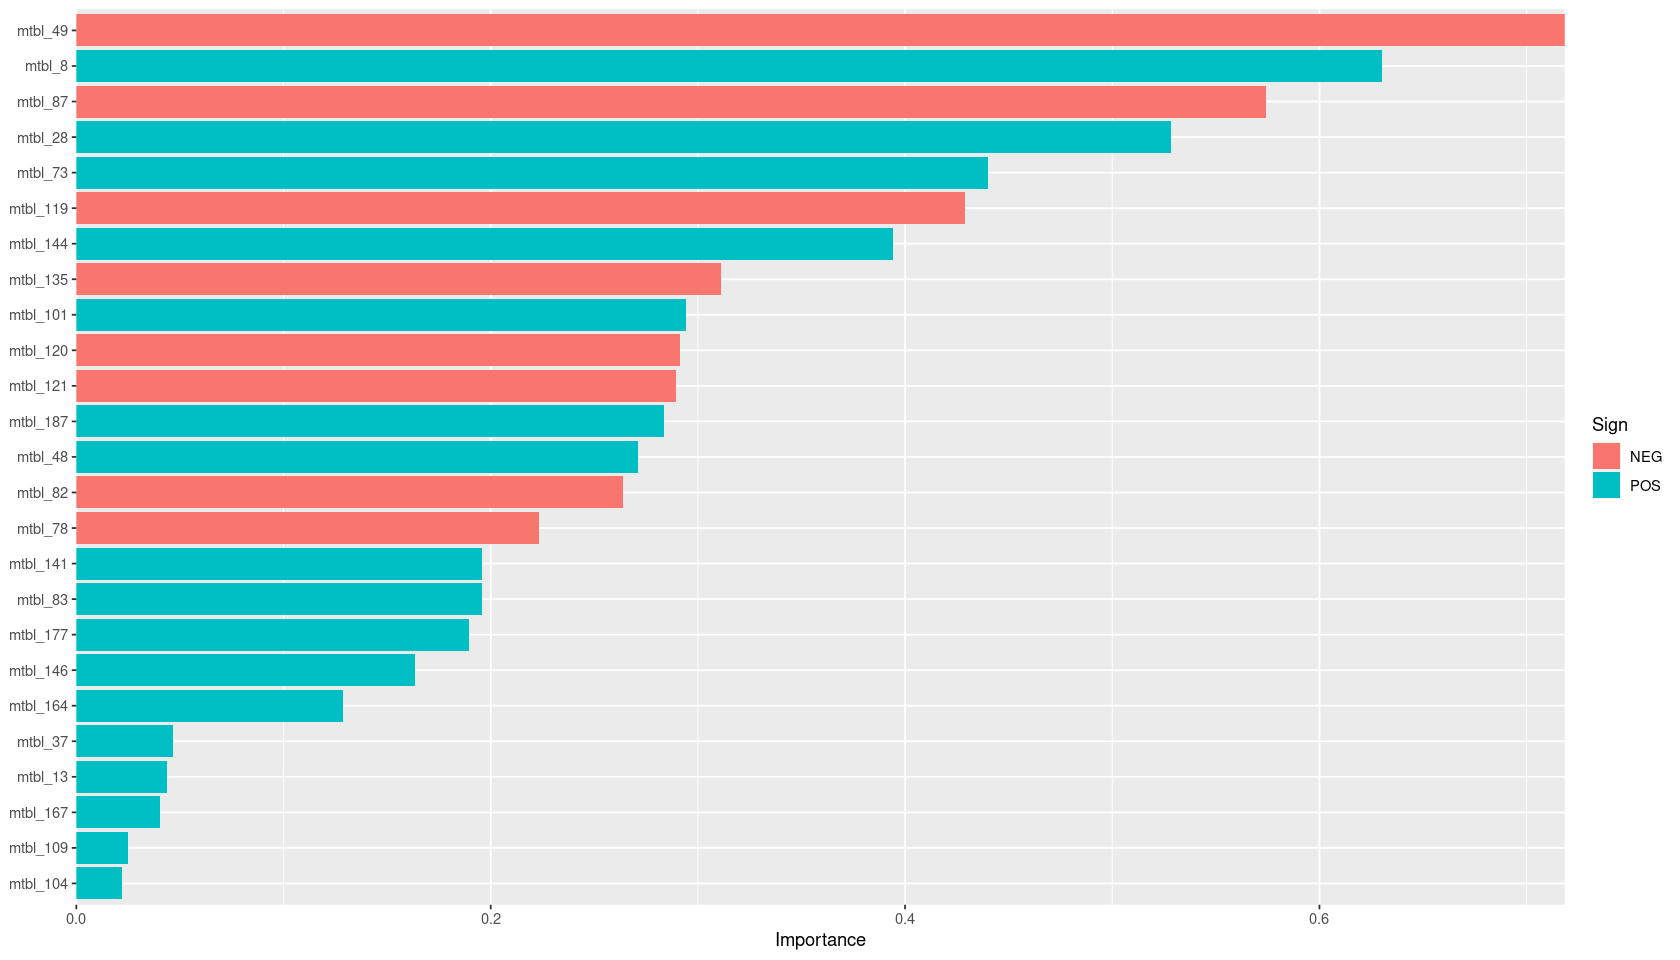

In [20]:
library("vip")

final_lasso %>%
  fit(mtbsl1_train) %>%
  pull_workflow_fit() %>%
  vi(lambda = lowest_roc$penalty) %>%
  mutate(
    Importance = abs(Importance),
    Variable = fct_reorder(Variable, Importance)
  ) %>%
  filter(Importance > 0) %>%
  ggplot(aes(x = Importance, y = Variable, fill = Sign)) +
  geom_col() +
  scale_x_continuous(expand = c(0, 0)) +
  labs(y = NULL)

## Testing the model

In [ ]:
lr_res <- last_fit(
  final_lasso,
  mtbsl1_split
) 

lr_res %>%
  collect_metrics()


In [ ]:
lr_res %>% collect_predictions() %>%
  group_by(.pred_class,Metabolic_syndrome) %>%
  summarise(N=n()) %>%
  spread(key = ".pred_class", value = N)

In [ ]:
mtbsl1_testing <- mtbsl1_prep %>% bake(testing(mtbsl1_split)) ## preprocess test data

final_lasso_fit <- fit(final_lasso, data = mtbsl1_train) ## fit final model on the training set

final_lasso_fit %>%
  predict(mtbsl1_testing, type = "class") %>%
  bind_cols(mtbsl1_testing) %>%
  # metrics(truth = Metabolic_syndrome, estimate = .pred_class)
  group_by(.pred_class,Metabolic_syndrome) %>%
  summarise(N=n()) %>%
  spread(key = ".pred_class", value = N)

In [ ]:
lr_auc <- 
  lr_res %>% 
  collect_predictions() %>% 
  roc_curve(Metabolic_syndrome,`.pred_Control Group`) %>% 
  mutate(model = "Logistic Regression")

autoplot(lr_auc)

## Add gender (factor) to the Lasso model

To add factors to the Lasso model (engine `glmnet`) we need to use [one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

In [ ]:
diab_dt <- model.matrix(~ ., mtbsl1[,"Gender"]) %>% as_tibble() %>% select(GenderMale) %>% rename(gender = GenderMale) %>% 
bind_cols(diab_dt)

head(diab_dt)

#### Interactive exercise

We'll now rerun a Lasso-penalised logistic regression model including Gender as feature, going together through the steps involved in Lasso models with `tidymodels`:

1. splitting the data
2. preprocessing
3. hyperparameters tuning
4. fitting the final model
5. predictions on the test set

In [ ]:
## code here


In [ ]:
## code here